In [1]:
import pandas as pd


In [2]:
df = pd.read_csv('monthly-production.csv')
df.tail()


,Date,Monthly beer production
471,1995-04-01,127.0
472,1995-05-01,151.0
473,1995-06-01,130.0
474,1995-07-01,119.0
475,1995-08-01,153.0


What is the type of **Date**?

In [3]:
# Object
type(df.Date[0])

str

Use **pandas.to_datetime** to **transform df.Date** in to a series of datetime object and assign it to a new column **date**.

In [4]:
df['date'] = pd.to_datetime(df.Date)
df.date.dtype

dtype('<M8[ns]')

In [5]:
df.head()

,Date,Monthly beer production,date
0,1956-01-01,93.2,1956-01-01
1,1956-02-01,96.0,1956-02-01
2,1956-03-01,95.2,1956-03-01
3,1956-04-01,77.1,1956-04-01
4,1956-05-01,70.9,1956-05-01


The earliest date in the datetime series.

In [6]:
df['date'].min()

Timestamp('1956-01-01 00:00:00')

The latest date in the datetime series.

In [7]:
df['date'].max()

Timestamp('1995-08-01 00:00:00')

In [8]:
df = df.drop(columns=['Date']).set_index('date').copy()

In [9]:
df.head()

,Monthly beer production
date,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


**Visualize the time series of 'Monthly beer production'.**

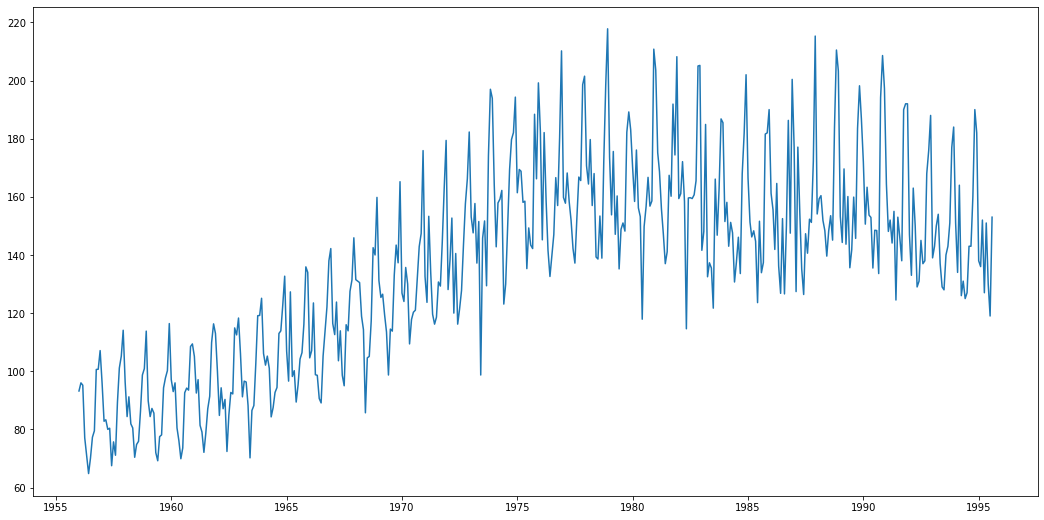

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
#df.set_index(df.date,drop=True, inplace=True)
plt.figure(figsize=(18,9))
plt.plot(df.index, df["Monthly beer production"], linestyle="-")
plt.xlabel=('Dates')
plt.ylabel=('Total Production')
plt.show();

From the plot above, we can see the dataset is not stationary.

Get yearly counts of data using **Resample**.

<AxesSubplot:title={'center':'Yearly Counts'}, xlabel='date'>

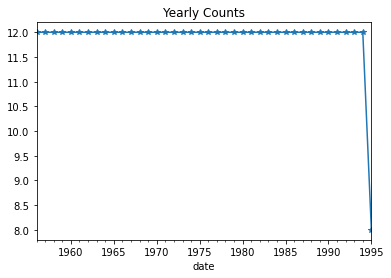

In [12]:
df['Monthly beer production'].resample('Y').count().plot(title='Yearly Counts', marker='*')


Get yearly mean and median, respectively.

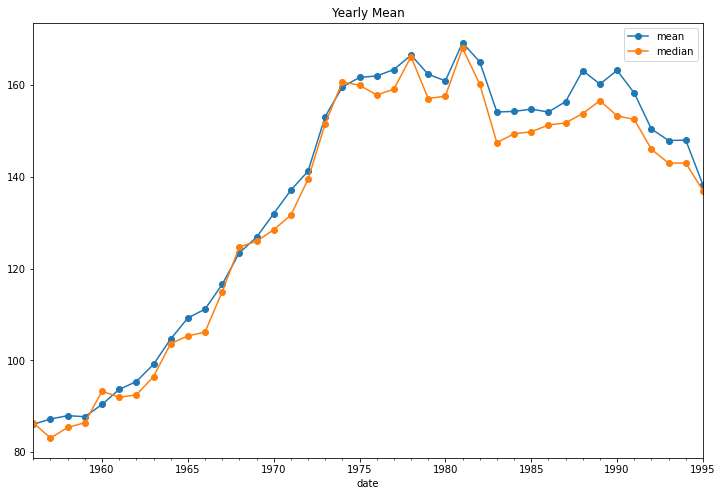

In [13]:
from matplotlib.pyplot import figure

figure(figsize=(12,8))
df['Monthly beer production'].resample('Y').mean().plot(title='Yearly Mean', marker='o', label='mean')
df['Monthly beer production'].resample('Y').median().plot(title='Yearly Mean', marker='o', label='median')
plt.legend(loc='best')
plt.show()

**Get 12-month rolling moving average.**

<AxesSubplot:title={'center':'12 Month Rolling Average'}, xlabel='date'>

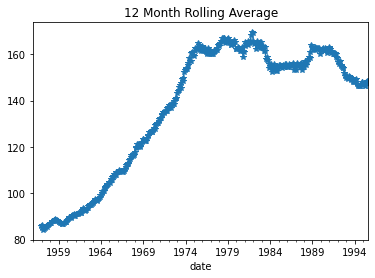

In [98]:
df['Monthly beer production'].rolling(12).mean().plot(title='12 Month Rolling Average', marker='*')

**Plot seasonal decomposition of monthly beer production.**

<Figure size 2520x720 with 0 Axes>

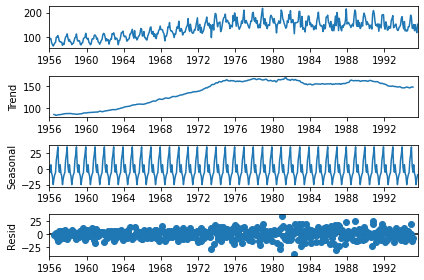

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

figure(figsize=(35,10))
decomposition = seasonal_decompose(df, model='additive')
fig=decomposition.plot()


**Check Stationarity**

In [19]:
# ADF test before differencing
from statsmodels.tsa.stattools import adfuller 
df_resample = df.resample('M').mean()
adf = adfuller(df_resample['Monthly beer production'], 12)
print("\nStatistics analysis\n")
print("Statistic Test : " , adf[0])
print("p-value : " , adf[1])
print("# n_lags : " , adf[2])
print("No of observation: " , adf[3])
for key,value in adf[4].items():
    print(f" critical value {key} : {value}")


Statistics analysis

Statistic Test :  -2.2618830885191996
p-value :  0.18455617822316595
# n_lags :  3
No of observation:  36
 critical value 1% : -3.626651907578875
 critical value 5% : -2.9459512825788754
 critical value 10% : -2.6116707716049383


In [21]:
# ADF Test after differencing
df_resample = df.resample('Y').mean()
df_resample['first_diff'] = df_resample['Monthly beer production'].diff()
df_resample.dropna(inplace = True)

adf = adfuller(df_resample['first_diff'], 12)

print('\nStatistics analysis\n')
print('Statistic Test:' , adf[0])
print('p-value:', adf[1])
print('# n_lags:', adf[2])
print('No of observation:', adf[3])
for key,value in adf[4].items():
    print(f" critical value {key} : {value}")



Statistics analysis

Statistic Test: -1.1217576986775208
p-value: 0.7063176597199151
# n_lags: 2
No of observation: 36
 critical value 1% : -3.626651907578875
 critical value 5% : -2.9459512825788754
 critical value 10% : -2.6116707716049383


In [101]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df)

(0.01, False)

In [22]:
from pmdarima.arima import ADFTest
adf_test1= ADFTest(alpha=0.5)
adf_test1.is_stationary(df)

/var/folders/wq/xsf5tghd3gs2m1gcj_d759z00000gn/T/ipykernel_5926/2966907901.py:3: DeprecationWarning: is_stationary is deprecated and will be removed in a future release of pmdarima. Use should_diff instead.
  adf_test1.is_stationary(df)


(0.01, False)

From the result above we can see the dataset is stationarity.(Stationarity is very import in time series analysis. Stationarity means that statistical properites of a time series doesn't change over time.)

ADFTest.should_diff() will return pval, sig.
(pval: float The computed P-value of the test.

sig: bool Whether the P-value is significant at the alpha level. More directly, whether to difference the time series.)

**Why is Augmented Dickey–Fuller test (ADF Test) so important in Time Series Analysis**

https://medium.com/@cmukesh8688/why-is-augmented-dickey-fuller-test-adf-test-so-important-in-time-series-analysis-6fc97c6be2f0

* Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.
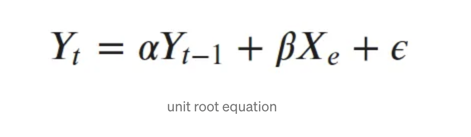

* The presence of a unit root means the time series is non-stationary.
* A key point to remember here is: Since the null hypothesis assumes the presence of unit root, that is α=1, the **p-value < 0.05 or 0.01**  in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

In [102]:
# split data into training data and test data
train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [103]:
print(train_data.shape, test_data.shape)

(464, 1) (12, 1)


**use auto_arima to find the best (p, d, q) (P, D, Q) and forecast beer production for the last 12 months.**


from the result below, the best(p, d, q) (P, D, Q) are Best model:  ARIMA(2,1,3)(2,1,2) whose AIC is the least.

In [104]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [105]:
import pmdarima as pm
from pmdarima import auto_arima

# Seasonal - fit stepwise auto-ARIMA
model = pm.auto_arima(train_data, start_p=0, d =1, start_q=0,
                      max_p=4, max_d=3, max_q=3,
                      D=1, start_Q=0, 
                      max_P=2,max_D=3, max_Q=3, m=12,
                      seasonal=True,
                      error_action='warn',
                      trace=True,
                      stepwise=True,
                      suppress_warnings=True,
                      random_state=20,
                      n_fits=50)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3850.011, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3912.334, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3721.925, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=3391.779, Time=1.90 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=3555.249, Time=0.41 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=2.81 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=3385.198, Time=12.97 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=3387.117, Time=19.35 sec
 ARIMA(0,1,1)(0,1,3)[12]             : AIC=3386.804, Time=21.03 sec
 ARIMA(0,1,1)(1,1,3)[12]             : AIC=3383.861, Time=42.03 sec
 ARIMA(0,1,1)(2,1,3)[12]             : AIC=inf, Time=87.87 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=3377.716, Time=41.35 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=3384.586, Time=23.28 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=3687.367, Time=49.01 sec
 ARIMA(1,1,1)(2,1,2)[

/Users/lydialiu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


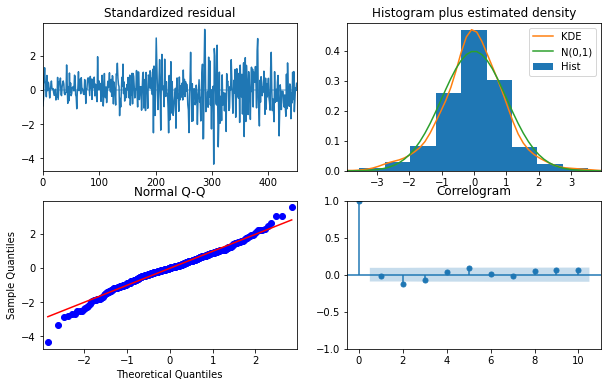

In [106]:
model.plot_diagnostics(figsize=(10,6))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s forecast.

**Visualize your forecast by plotting it together with the true values.**

**Professor method**

In [ ]:
fcst, conf_int = model.predict(n_predict=12, return_conf_int = True, alpha = 0.2)
fcst =pd.Series(data=fcst, index=df.index[-12:])

In [ ]:
plt.figure(figsize=(18,9))
df[-100:]['Monthly beer production'].plot(label='True values')
fcst.plot(label='SARIMA predict')
plt.legend(loc='best')

In [78]:
#forecast
# prediction = pd.DataFrame(model.predict(n_periods = 12),index=test_data.index)
# prediction.columns=['Monthly beer production']
# prediction

,Monthly beer production
date,
1994-09-01,134.739335
1994-10-01,157.681241
1994-11-01,180.357368
1994-12-01,183.218479
1995-01-01,142.008660
1995-02-01,140.742822
1995-03-01,148.938563
1995-04-01,134.229361
1995-05-01,137.497827


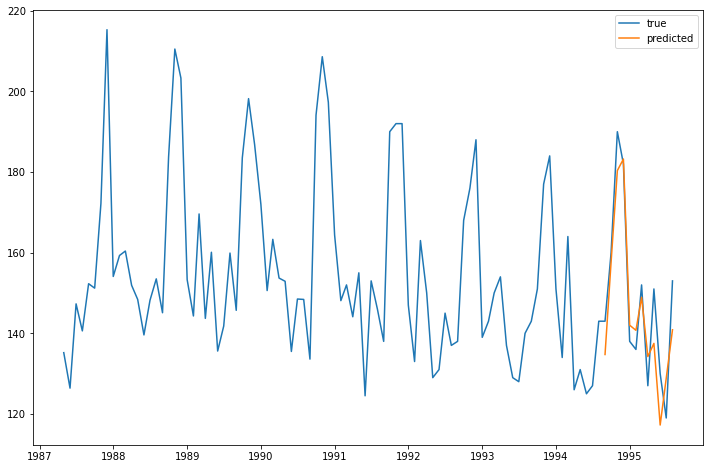

In [77]:
plt.figure(figsize=(12,8))

#df[-100:]['Monthly beer production'].plot(label="True values")
plt.plot(df[-100:], label='true')
plt.plot(prediction, label='predicted')
plt.legend(loc='best')
plt.show()

In [80]:
from sklearn.metrics import r2_score
test_data['Predicted Monthly beer production'] = prediction
r2_score(test_data['Monthly beer production'], test_data['Predicted Monthly beer production'])

/var/folders/wq/xsf5tghd3gs2m1gcj_d759z00000gn/T/ipykernel_99982/1781280242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted Monthly beer production'] = prediction


0.8281621747705887

we can see that the model works good for prediction.